In [1]:
import torch
from torch.utils.data import IterableDataset
from torchtext.data import TabularDataset
from torch.utils.data import DataLoader
from torchtext import data

# Traemos los datos de mongo

In [2]:
import pymongo

myclient = pymongo.MongoClient("mongodb://localhost:27017/")

db = myclient["abortion"]

In [3]:
base_query = {}
rt_query = {**base_query, **{"tweet.retweeted_status": {"$exists": True}}}


tweets = db.abortion.find(base_query)
rts = db.abortion.find(rt_query)


print("Tenemos {:.2f}M tweets ({:.2f}M RTs)".format(tweets.count() / 1e6, db.abortion.count_documents(rt_query) / 1e6))

/home/damifur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if __name__ == '__main__':


Tenemos 0.61M tweets (0.46M RTs)


In [4]:
cantidad_de_usuarios = len(db.abortion.find(rt_query).distinct('user'))

print("Cantidad de retwitteros : {}".format(cantidad_de_usuarios))

Cantidad de retwitteros : 219183


# Grafo de Retweets

In [5]:
import networkx as nx

full_g = nx.Graph()
vertex_ids = set()


for retweet in rts:
    original_tweet = retweet["tweet"]["retweeted_status"]
    full_g.add_edge(retweet["user"], original_tweet["user"]["id"])

In [6]:
n = len(full_g.nodes)
m = len(full_g.edges)
complete = n * (n-1) / 2

print("Nodos: {:.2f}M".format((n / 1e6)))
print("Ejes: {:.2f}M".format((m / 1e6)))

Nodos: 0.23M
Ejes: 0.40M


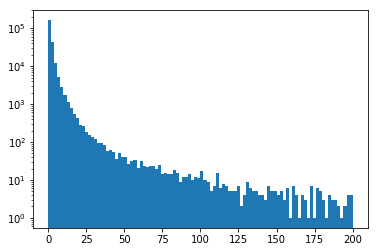

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

degrees = np.array([full_g.degree(node) for node in full_g.nodes()])

plt.hist(degrees, range=(0, 200), bins=100);
plt.semilogy();

In [8]:
def subgraph_strong_nodes(g, n):
    """
    Devuelve subgrafo con nodos de grado mayor a n
    """
    good_nodes = [node for node in g.nodes() if g.degree(node) >= n]
    
    return g.subgraph(good_nodes)

g = subgraph_strong_nodes(full_g, 5)

print("Nos quedan {:.2f}M nodos (antes eran {:.2f}M)".format(
    len(g.nodes) / 1e6,
    len(full_g.nodes) / 1e6
))
print("Componentes conexas = {}".format(len(list(nx.connected_components(g)))))

Nos quedan 0.02M nodos (antes eran 0.23M)
Componentes conexas = 875


In [9]:
components = list(nx.connected_components(g))

print("Componentes conexas = {}".format(len(components)))

print("Componente 0  --> {:<6} usuarios".format(len(components[0])))

resto = [len(components[i]) for i in range(1, len(components))]
print("Restantes     --> {:<6} usuarios".format(sum(resto)))

Componentes conexas = 875
Componente 0  --> 19000  usuarios
Restantes     --> 923    usuarios


In [10]:
g = g.subgraph(components[0])

# Corremos Louvain para encontrar las comunidades

In [11]:
partitions = {}

In [12]:
import cylouvain
import time
from collections import Counter

user_threshold = 100

for resolution in  [1, 1.5, 2, 3, 5, 6, 7, 10, 15]:
    begin = time.time()
    print("resolución {:.2f}".format(resolution), end="")
    
    partition = cylouvain.best_partition(g, resolution=resolution)
    end = time.time()
    
    num_partitions = len(set(partition.values()))
    counter = Counter(partition.values())
    
    
    important_partitions = len([_ for x in counter.items() if x[1] > user_threshold])
    
    print("---> {} particiones ({} con más de {} usuarios)".format(
        num_partitions,
        important_partitions,
        user_threshold,
    ))
    #print("Tiempo: {:.2f} minutos".format((end - begin) / 60))
    partitions[resolution] = partition

resolución 1.00---> 28 particiones (10 con más de 100 usuarios)
resolución 1.50---> 19 particiones (8 con más de 100 usuarios)
resolución 2.00---> 11 particiones (7 con más de 100 usuarios)
resolución 3.00---> 10 particiones (5 con más de 100 usuarios)
resolución 5.00---> 6 particiones (4 con más de 100 usuarios)
resolución 6.00---> 6 particiones (4 con más de 100 usuarios)
resolución 7.00---> 6 particiones (4 con más de 100 usuarios)
resolución 10.00---> 5 particiones (3 con más de 100 usuarios)
resolución 15.00---> 4 particiones (3 con más de 100 usuarios)


In [13]:
modularity = 10.0
partition = partitions[modularity]
partition_to_ids = {partition_number:[] for partition_number in range(len(set(partition.values())))}

num_partitions = len(set(partition.values()))
for user_id, user_partition in partition.items():
    partition_to_ids[user_partition].append(user_id)

In [14]:
cache_users = {}
def get_user(user_id):
    if user_id not in cache_users:
        user = db.users.find_one({"id": user_id})
        if user:
            cache_users[user_id] = user
        else:
            cache_users[user_id] = None
    return cache_users[user_id] 
    

In [15]:
import nltk
from tweepy import TweepError
from collections import Counter

users_with_tweets = db.abortion.find({
    **base_query
}).distinct('user')
    

    
def most_followed_by(followers, N=5):
    """
    Returns the ids of the users most retweeted by followers
    
    Arguments:
    ---------
    
    followers: iterable of dicts/user documents
        The dicts should have the key 'friends_ids' 
        
    N: int (default=5)
        Number of top-followed users to return

    
    """
    fd = nltk.FreqDist()
    
    for follower in followers:
        try:
            for fid in follower["friends_ids"]:
                fd[fid] += 1
        except KeyError as e:
            """ No tiene friends_ids """
            continue
        
    return fd.most_common(N)

def most_retweeted(users, N=5):
    user_ids = [u["id"] for u in users]
    
    retweets = db.abortion.find({
        **rt_query,
        **{
            "user": {"$in": user_ids},
        }
    })
    
    counter = Counter(tweet["tweet"]["retweeted_status"]["user"]["id"] for tweet in retweets)
    
    return counter.most_common(N)
    
    

def users_of_community(db, partition_number, has_tweets=True):    
    user_ids = partition_to_ids[partition_number]
    
    if has_tweets:
        user_ids = set(user_ids).intersection(users_with_tweets)
    return db.users.find({
        "id": {"$in": list(user_ids)}
    })


def community_info(partition_number, 
                   num_users=5, num_tweets=5, followers=10,
                   user_threshold=10):
    users = list(users_of_community(db, partition_number))
    
    if len(users) <= user_threshold:
        return
    
    print(("*" * 40 + '\n') * 4)
    print("Partición {}".format(partition_number))
    print("Cantidad de usuarios: {}".format(len(users)))

    
    user_ids = [user["id"] for user in users]
    num_tweets = db.abortion.count_documents({
        **base_query,
        **{"user": {"$in": user_ids}}
    })
    print("Cantidad de tweets: {}".format(num_tweets))
    
    """
    print("\n\nUsuarios más seguidos\n\n")
    for i, (user_id, count) in enumerate(most_followed_by(users, followers)):
        try:
            user = get_user(user_id)
            print("{0:<2}. {2:<35} (@{1:<20}) -- {3:<6} seguidores".format(i+1, user["screen_name"], user["name"], count))
        except TweepError as e:
            print("{} - {}".format(user_id, e))
    """
    print("\n\nUsuarios más RT \n\n")
    for i, (user_id, count) in enumerate(most_retweeted(users, followers)):
        try:
            user = get_user(user_id)
            if user:
                print("{0:<2}. {2:<22} (@{1:<15}) -- {3:<6} RT".format(
                    i+1, 
                    user["screen_name"][:20], 
                    user["name"][:15], 
                    count))
        except TweepError as e:
            print("{} - {}".format(user_id, e))
    
    
    for user in users[:num_users]:
        print((('=')*50 + '\n')*3)

        print("{1} (@{0})".format(user['screen_name'], user['name']))
        print("Ubicación: ", user['location'])
        print("Descripción: ", user['description'])
        print(user['id'])
        
        query = {
            **base_query,
            **{
                "tweet.user.id": user["id"], 
            }
        }
        
        tweets = db.abortion.find(query).limit(num_tweets)
        
        print("\nTweets:")
        
        for tweet in tweets:
            if 'tweet' in tweet and 'full_text' in tweet['tweet']:
                print(tweet['tweet']['full_text'])

In [16]:
for i in range(num_partitions):
    community_info(i, num_users=10, followers=20, num_tweets=3, user_threshold=user_threshold)

****************************************
****************************************
****************************************
****************************************

Partición 1
Cantidad de usuarios: 13044
Cantidad de tweets: 165422


Usuarios más RT 


1 . LifeNews.com           (@LifeNewsHQ     ) -- 16326  RT
2 . Live Action            (@LiveAction     ) -- 4603   RT
3 . Charlie Kirk           (@charliekirk11  ) -- 3894   RT
4 . 🇺🇸👶✝️I am ProLi        (@Prolife_IAM    ) -- 3577   RT
5 . Abby Johnson           (@AbbyJohnson    ) -- 2144   RT
6 . Judicial Watch         (@JudicialWatch  ) -- 2039   RT
7 . March for Life         (@March_for_Life ) -- 2022   RT
8 . LAYLA {⭐}              (@LaylaAlisha11  ) -- 1991   RT
9 . Lila Rose              (@LilaGraceRose  ) -- 1990   RT
10. Fr. Frank Pavon        (@frfrankpavone  ) -- 1986   RT
11. Educating Liber        (@Education4Libs ) -- 1612   RT
12. Cori #Trump2020        (@Cocofritz      ) -- 1530   RT
13. Rod The Nationa        (@RodHillis1

After fighting an intense legal battle to keep out evidence , #PlannedParenthood's own attorney just opened the door to disturbing testimony in our trial . This is a big deal . We can defeat Planned Parenthood but we need you . Sign our petition today . https://t.co/XEzTRTb7UU
Join me right now in Mexico where I'm on stage to debate protecting innocent human life in the womb : https://t.co/b8cgMhfJHG #prolife
@The_War_Economy Here's his district . He's soft on border issues & abortion . There's no mystery he's IC . https://t.co/jgQAdMxPxY
@The_War_Economy Here's his district . He's soft on border issues & abortion . There's no mystery he's IC . https://t.co/jgQAdMxPxY
. @giannajessen to Congress : “ If abortion is merely about women ’ s rights , then where were mine ? ” Human rights begin in the womb . We must protect the rights of ALL women — born and unborn . #ProLife #ChooseLife 💓 👣 https://t.co/nyxmls9ACJ

Rhianna Rita Starr (@rhianna)
Ubicación:  New York, NY
Descripción:  Tarot c

Cantidad de tweets: 1061


Usuarios más RT 


1 . charity Mukuba         (@mukuba_charity ) -- 85     RT
2 . Wuod Japuonj           (@OsumbaJM       ) -- 57     RT
3 . Amos Kilanya           (@AmosKilanya    ) -- 42     RT
4 . Digital Native🇰        (@EmodiaBenjamin ) -- 41     RT
5 . Monica Nyaga.          (@nyagamoniq     ) -- 41     RT
6 . Lilian🇰🇪               (@PstLily        ) -- 40     RT
7 . Nelson Amenya          (@amenya_nelson  ) -- 37     RT
8 . Julius 🇰🇪              (@J_Kikwai       ) -- 28     RT
9 . Pizzahmwitu            (@pizzahmwitu    ) -- 19     RT
10. Kibet Vincent R        (@KibetVincentRo1) -- 18     RT
11. Susan Wanjiru          (@swanjirul      ) -- 15     RT
12. Catholic MPs Ke        (@CatholicmpsKE  ) -- 11     RT
13. Bshp Albert            (@BshpAlbert     ) -- 11     RT
14. Charity                (@charity_sang   ) -- 11     RT
15. Sir Ian                (@ianowilid      ) -- 10     RT
16. willie ngugi           (@williengugi3   ) -- 10     RT
17. Arthur

Kenya is a GOD fearing nation , why are we now propagating laws on abortion , homosexuality . Have we stopped fearing GOD ? I am a sad Kenyan today #LetterToTheState
Today I ask myself , what is of more value to this nation . Money or the sanctity of life ? Let us not destroy the future of Kenya with the ICPD Summit.Say no to abortion #LetterToTheState
The Bible is Clear , Murder is sin and those who practise it they have their place in the eternal Hell fire ! I am asking today , why then legalize abortion ? Aren't you aware the Bible warns against killing ? #LetterToTheState
I am not ashamed of the gospel , because it is the power of God for the salvation of everyone who believes : This gospel says NO TO SIN , , , Homosexuality is SinAbortion is Sin #LetterToTheState https://t.co/ptPx5btRrl
Dear Kenyans , This is our country , and we are a GOD fearing people.JESUS paid a very heavy price for our redemption and salvation.Abortion is murder , we cannot allow it . #LetterToTheStatehttps 

Cantidad de tweets: 49824


Usuarios más RT 


1 . NARAL                  (@NARAL          ) -- 1469   RT
2 . EMILY's List           (@emilyslist     ) -- 964    RT
3 . Senator Mazie H        (@maziehirono    ) -- 876    RT
4 . Lauren Rankin          (@laurenarankin  ) -- 760    RT
5 . Rewire.News            (@Rewire_News    ) -- 583    RT
6 . Janis Irwin            (@JanisIrwin     ) -- 470    RT
7 . Center for Repr        (@ReproRights    ) -- 412    RT
8 . Planned Parenth        (@PPact          ) -- 394    RT
9 . Planned Parenth        (@PPFA           ) -- 344    RT
10. UNFPA                  (@UNFPA          ) -- 280    RT
11. Nairobi Summit         (@NairobiSummit  ) -- 274    RT
12. The Unruly Squi        (@educatedadult1 ) -- 261    RT
13. Leah Torres, MD        (@LeahNTorres    ) -- 250    RT
14. prochoiceforall        (@prochoiceforal1) -- 236    RT
15. robin heide            (@robinandriver  ) -- 227    RT
16. John Pavlovitz         (@johnpavlovitz  ) -- 217    RT
17. Renee

There ’ s a reason Shelby County , which gutted voting rights was decided two years before Obergefell — and we heard minimal repulse from LGBTQ organizations . Similar reasons they are silent around abortion , contraception , sex work , among others . We ’ re asterisks .
This week , the U . S . Ambassador to the United Nations objected to the use of the phrase " sexual and reproductive health " because it could " suggest a right to abortion . " Make no mistake : They are coming for women's freedom on a global scale . https://t.co/1BFBnS2ppf
@gaywonk @alexkotch @ebruenig No thank you . Anti-abortion " leftists " need to gtfo .
I'm done with Democratic strategists worrying that supporting abortion rights will cause a candidate to lose . 73 % of Americans want Roe v . Wade to remain the law of the land . But more importantly , abortion is a fundamental right . We don't discard human rights to win elections .
Refusing to support abortion as a candidate only allows abortion stigma to flouri

What is it with these men ? Is it a fetish ? Missouri health director kept spreadsheet of Planned Parenthood patients ’ periods https://t.co/NeyBzTvbvW
Remember when Adriana Cohen on @RealClearNews said “ It's well-documented that many conservative leaders & activists have been unwelcome or outright banned from speaking at colleges and universities , including pro-life & conservative commentator Ben Shapiro . ” Are they ok w this 👇 https://t.co/VIc1NQJxCg
There ’ s literally a whole fucking party dedicated to anti-abortion hardlining , he can join that one , christ allflippingmighty , why would anyone even ask this https://t.co/Q9ArLUeWV9


# Armamos datasets con los tweets de cada comunidad

In [17]:
def tweets_of_community(partition_num):
    users = list(users_of_community(db, partition_num))
    user_ids = [user["id"] for user in users]
    tweets = [tweet['tweet']['full_text'] for tweet in db.abortion.find({**base_query,**{"user": {"$in": user_ids}}}, {"tweet.full_text": 1})]
    return tweets

In [18]:
tweets_favor = tweets_of_community(3)
tweets_agains = tweets_of_community(1)

In [19]:
w_train = open("abortion_favor_dataset_train.tsv", 'w')
w_train.write("text\n")
for tweet in tweets_favor[:-200]:
    w_train.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_train.close()

w_val = open("abortion_favor_dataset_val.tsv", 'w')
w_val.write("text\n")
for tweet in tweets_favor[-200:-100]:
    w_val.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_val.close()

w_test = open("abortion_favor_dataset_test.tsv", 'w')
w_test.write("text\n")
for tweet in tweets_favor[-100:]:
    w_test.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_test.close()

w_train_against = open("abortion_against_dataset_train.tsv", 'w')
w_train_against.write("text\n")
for tweet in tweets_agains[:-200]:
    w_train_against.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_train_against.close()

w_val_against = open("abortion_against_dataset_val.tsv", 'w')
w_val_against.write("text\n")
for tweet in tweets_agains[-200:-100]:
    w_val_against.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_val_against.close()

w_test_against = open("abortion_against_dataset_test.tsv", 'w')
w_test_against.write("text\n")
for tweet in tweets_agains[-100:]:
    w_test_against.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_test_against.close()

w_all = open("abortion_complete_dataset.tsv", 'w')
w_all.write("text\n")
for tweet in tweets_agains:
    w_all.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
for tweet in tweets_favor:
    w_all.write("{}\n".format(tweet.replace('\n','').replace('\t','')))
w_all.close()

In [20]:
TEXT = data.Field(
    tokenizer_language='en',
    lower=True,
    init_token='<sos>',
    eos_token='<eos>',
    batch_first=True,
)

In [21]:
train_favor, val_favor, test_favor = data.TabularDataset.splits(path="", train="abortion_favor_dataset_train.tsv", validation="abortion_favor_dataset_val.tsv", test="abortion_favor_dataset_test.tsv", format="tsv", fields=[('text', TEXT)])
train_against, val_against, test_against = data.TabularDataset.splits(path="", train="abortion_against_dataset_train.tsv", validation="abortion_against_dataset_val.tsv", test="abortion_against_dataset_test.tsv", format="tsv", fields=[('text', TEXT)])
train_all = data.TabularDataset(path="abortion_complete_dataset.tsv", format="tsv", fields=[("text", TEXT)])

In [22]:
TEXT.build_vocab(train_all, vectors="glove.6B.300d")
print(f"We have {len(TEXT.vocab)} tokens in our vocabulary")

We have 100087 tokens in our vocabulary


In [30]:
def dataset2example(dataset):
    examples = list(map(lambda example: ['_bos_']+ example.text + ['_eos_'], dataset.examples))
    examples = [item for example in examples for item in example]
    example = data.Example()
    setattr(example, 'text', examples)
    return data.Dataset([example], fields={'text': TEXT})

In [32]:
train_favor = dataset2example(train_favor)
val_favor = dataset2example(val_favor)
test_favor = dataset2example(test_favor)

In [47]:
train_against = dataset2example(train_against)
val_against = dataset2example(val_against)
test_against = dataset2example(test_against)

# Armamos un LM usando RNN

In [33]:
device = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 32
BPTT_LEN = 70

train_favor_iter, val_favor_iter, test_favor_iter = data.BPTTIterator.splits(
    (train_favor, val_favor, test_favor),
    batch_size=BATCH_SIZE,
    bptt_len=BPTT_LEN, # this is where we specify the sequence length
    device=device,
    repeat=False,
#     sort_key=lambda x: x,
    sort=False)

In [48]:
train_against_iter, val_against_iter, test_against_iter = data.BPTTIterator.splits(
    (train_against, val_against, test_against),
    batch_size=BATCH_SIZE,
    bptt_len=BPTT_LEN, # this is where we specify the sequence length
    device=device,
    repeat=False,
#     sort_key=lambda x: x,
    sort=False)

In [354]:
# iterator = data.BPTTIterator(train_all, batch_size=BATCH_SIZE, bptt_len=BPTT_LEN, device=device, repeat=False)

In [35]:
import torch.nn as nn

class RNNLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, pad_idx, hidden_size,
                 cell_class=nn.GRU, dropout=0.20):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=PAD_IDX)
        self.rnn = cell_class(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
    def forward(self, inp, hidden=None):
        """
        Inputs are supposed to be just one step (i.e. one letter)
        """
        # inputs = [batch_size, ]
        emb = self.embedding(inp)
        # emb = [batch, embedding_dim]
        # As all my examples are of the same length, there is no use 
        # in packing the input to the RNN
        rnn_outputs, hidden = self.rnn(emb, hidden)
        # hidden = [batch, hidden_dim]
        
        out = self.fc(self.dropout(rnn_outputs))
        # out = [batch, vocab size]

        return out, hidden

In [36]:
PAD_IDX = TEXT.vocab.stoi["<pad>"]
UNK_IDX = TEXT.vocab.stoi["<unk>"]
EOS_IDX = TEXT.vocab.stoi["<eos>"]
SOS_IDX = TEXT.vocab.stoi["<sos>"]

In [38]:
len(train_favor_iter)

908

In [41]:
import torch.optim as optim

HIDDEN_DIM = 256
vocab_size = TEXT.vocab.vectors.shape[0]
embedding_dim = TEXT.vocab.vectors.shape[1]

model = RNNLanguageModel(
    vocab_size, embedding_dim, 
    hidden_size=HIDDEN_DIM, pad_idx=PAD_IDX, dropout=0.4)

# Set weight for UNK to a random normal
model.embedding.weight.data.copy_(TEXT.vocab.vectors)
model.embedding.weight.data[UNK_IDX] = torch.randn(embedding_dim)


optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

model = model.to(device)
criterion = criterion.to(device)


## An example of calculating the loss
batch = next(iter(train_favor_iter))

preds, _ = model(batch.text)
preds = preds.view(-1, preds.shape[-1])


trg = batch.target.view(-1)
criterion(preds, trg)

tensor(11.5246, grad_fn=<NllLossBackward>)

In [42]:
import torch
import numpy as np

def train(model, iterator, optimizer, criterion):
    """
    Trains the model for one full epoch
    """
    epoch_loss = 0
    epoch_perplexity = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        text = batch.text
        trg = batch.target.view(-1)
        
        preds, _ = model(text)
        preds = preds.view(-1, preds.shape[-1])
        
        loss = criterion(preds, trg)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_perplexity += np.exp(loss.item())
    
    return epoch_loss / len(iterator), epoch_perplexity / len(iterator)


def evaluate(model, iterator, criterion):
    """
    Evaluates the model on the given iterator
    """
    epoch_loss = .0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text = batch.text
            trg = batch.target.view(-1)

            preds, _ = model(text)
            preds = preds.view(-1, preds.shape[-1])
            
            loss = criterion(preds, trg)

            epoch_loss += loss.item()
            
        loss = epoch_loss / len(iterator)
        
        perplexity = np.exp(loss)

    return loss, perplexity


In [281]:
# tweet = "#ProLife Scorecards for #Txlege are out & pretty ugly on the House side . The House Dems are becoming more radical on abortion ( from an average score of 6 % in ' 17 to 1 % in ' 19 ) , yet House Republicans earned less ProLife scores in 2019 ( from 93 % average in ' 17 to 73 % in ' 19 ) . https://t.co/15SvUswPug"
# tokens = TEXT_FAVOR.tokenize(tweet)
# tensor = torch.LongTensor([TEXT_FAVOR.vocab.stoi[tok] for tok in tokens]).view(1, -1)
# tensor.shape
# # preds, loss = model(tensor)
# # preds.view(-1, preds.shape[-1]).shape
# # tensor.view(-1).shape

torch.Size([1, 68])

In [43]:
from tqdm import tqdm
import time

N_EPOCHS = 40

best_valid_loss = float('inf')

early_stopping_tolerance = 3
epochs_without_improvement = 0

model_path = "/tmp/rnn_lang_model.pt"

pbar = tqdm(range(N_EPOCHS), ncols=1000)
for epoch in pbar:
    
    epoch_bar = tqdm(train_favor_iter)
    train_loss, train_perplexity = train(model, epoch_bar, optimizer, criterion)
    valid_loss, valid_perplexity = evaluate(model, val_favor_iter, criterion)

    
    desc = f' Train Loss: {train_loss:.3f} Perp: {train_perplexity:.2f}'
    desc += f' Val. Loss: {valid_loss:.3f} Perp: {valid_perplexity:.2f}'
    pbar.set_description(desc)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), model_path)
        print(f"Best model so far (Loss {best_valid_loss:.3f} Perp {valid_perplexity:.2f}) saved at {model_path}")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_tolerance:
            print("Early stopping")
            break

 15%|█▍        | 136/908 [07:46<48:54,  3.80s/it]


 32%|███▏      | 290/908 [16:42<35:17,  3.43s/it]


 49%|████▉     | 444/908 [25:39<27:05,  3.50s/it]


 66%|██████▌   | 598/908 [34:30<18:14,  3.53s/it]


 82%|████████▏ | 746/908 [2:03:27<08:47,  3.25s/it]


 98%|█████████▊| 894/908 [2:11:08<00:43,  3.08s/it]


100%|█████████▉| 907/908 [2:11:48<00:03,  3.16s/it]
 Train Loss: 5.690 Perp: 1149.92 Val. Loss: 5.174 Perp: 176.59:   2%|██████████████████████▎                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Best model so far (Loss 5.174 Perp 176.59) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:04<40:11,  3.21s/it]


 34%|███▍      | 310/908 [15:57<34:18,  3.44s/it]


 51%|█████     | 464/908 [24:24<22:20,  3.02s/it]


 68%|██████▊   | 618/908 [32:38<15:13,  3.15s/it]


 85%|████████▌ | 772/908 [40:58<07:02,  3.11s/it]


100%|█████████▉| 907/908 [48:12<00:03,  3.19s/it]
 Train Loss: 3.853 Perp: 51.05 Val. Loss: 4.229 Perp: 68.67:   5%|████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 4.229 Perp 68.67) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:27<44:12,  3.53s/it]


 34%|███▍      | 310/908 [16:51<31:08,  3.12s/it]


 51%|█████     | 464/908 [25:14<27:16,  3.69s/it]


 68%|██████▊   | 618/908 [33:38<16:21,  3.38s/it]


 85%|████████▌ | 772/908 [42:20<07:11,  3.18s/it]


100%|█████████▉| 907/908 [49:58<00:03,  3.58s/it]
 Train Loss: 3.145 Perp: 24.30 Val. Loss: 3.676 Perp: 39.47:   8%|███████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 3.676 Perp 39.47) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:45<42:08,  3.36s/it]


 34%|███▍      | 310/908 [17:17<35:39,  3.58s/it]


 51%|█████     | 464/908 [26:05<23:19,  3.15s/it]


 68%|██████▊   | 618/908 [34:54<15:48,  3.27s/it]


 85%|████████▌ | 772/908 [43:48<07:46,  3.43s/it]


100%|█████████▉| 907/908 [51:45<00:03,  3.51s/it]
 Train Loss: 2.761 Perp: 16.39 Val. Loss: 3.326 Perp: 27.84:  10%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 3.326 Perp 27.84) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [09:13<44:36,  3.56s/it]


 34%|███▍      | 310/908 [17:56<32:50,  3.29s/it]


 51%|█████     | 464/908 [26:46<27:03,  3.66s/it]


 68%|██████▊   | 618/908 [35:23<16:35,  3.43s/it]


 85%|████████▌ | 772/908 [44:03<07:15,  3.20s/it]


100%|█████████▉| 907/908 [51:38<00:03,  3.29s/it]
 Train Loss: 2.511 Perp: 12.71 Val. Loss: 3.065 Perp: 21.44:  12%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 3.065 Perp 21.44) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:39<46:49,  3.74s/it]


 34%|███▍      | 310/908 [17:27<36:13,  3.64s/it]


 51%|█████     | 464/908 [26:15<25:30,  3.45s/it]


 68%|██████▊   | 618/908 [35:10<17:24,  3.60s/it]


 85%|████████▌ | 772/908 [44:05<07:39,  3.38s/it]


100%|█████████▉| 907/908 [51:57<00:03,  3.98s/it]
 Train Loss: 2.332 Perp: 10.59 Val. Loss: 2.862 Perp: 17.50:  15%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.862 Perp 17.50) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [09:13<43:33,  3.48s/it]


 34%|███▍      | 310/908 [18:16<34:54,  3.50s/it]


 51%|█████     | 464/908 [27:24<24:56,  3.37s/it]


 68%|██████▊   | 618/908 [36:09<16:02,  3.32s/it]


 85%|████████▌ | 772/908 [44:39<07:56,  3.50s/it]


100%|█████████▉| 907/908 [52:16<00:03,  3.17s/it]
 Train Loss: 2.196 Perp: 9.23 Val. Loss: 2.704 Perp: 14.94:  18%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.704 Perp 14.94) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:40<44:20,  3.54s/it]


 34%|███▍      | 310/908 [17:20<32:49,  3.29s/it]


 51%|█████     | 464/908 [26:08<25:00,  3.38s/it]


 68%|██████▊   | 618/908 [34:54<16:40,  3.45s/it]


 85%|████████▌ | 772/908 [43:44<07:29,  3.31s/it]


100%|█████████▉| 907/908 [51:43<00:03,  3.59s/it]
 Train Loss: 2.089 Perp: 8.28 Val. Loss: 2.572 Perp: 13.10:  20%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.572 Perp 13.10) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [09:02<43:49,  3.50s/it]


 34%|███▍      | 310/908 [17:54<32:29,  3.26s/it]


 51%|█████     | 464/908 [26:49<25:14,  3.41s/it]


 68%|██████▊   | 618/908 [35:55<17:46,  3.68s/it]


 85%|████████▌ | 772/908 [44:59<07:00,  3.09s/it]


100%|█████████▉| 907/908 [52:24<00:03,  3.08s/it]
 Train Loss: 2.004 Perp: 7.59 Val. Loss: 2.475 Perp: 11.89:  22%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.475 Perp 11.89) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:07<38:38,  3.08s/it]


 34%|███▍      | 310/908 [16:09<33:11,  3.33s/it]


 51%|█████     | 464/908 [24:16<22:00,  2.97s/it]


 68%|██████▊   | 618/908 [32:34<14:31,  3.00s/it]


 85%|████████▌ | 772/908 [40:53<06:55,  3.06s/it]


100%|█████████▉| 907/908 [48:12<00:03,  3.27s/it]
 Train Loss: 1.935 Perp: 7.08 Val. Loss: 2.416 Perp: 11.20:  25%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.416 Perp 11.20) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:30<37:30,  2.99s/it]


 34%|███▍      | 310/908 [16:55<30:44,  3.09s/it]


 51%|█████     | 464/908 [25:30<26:52,  3.63s/it]


 68%|██████▊   | 618/908 [34:01<15:08,  3.13s/it]


 85%|████████▌ | 772/908 [42:30<07:05,  3.13s/it]


100%|█████████▉| 907/908 [50:04<00:03,  3.40s/it]
 Train Loss: 1.877 Perp: 6.67 Val. Loss: 2.379 Perp: 10.79:  28%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.379 Perp 10.79) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:51<47:44,  3.81s/it]


 34%|███▍      | 310/908 [17:29<32:55,  3.30s/it]


 51%|█████     | 464/908 [26:07<23:55,  3.23s/it]


 68%|██████▊   | 618/908 [34:46<16:38,  3.44s/it]


 85%|████████▌ | 772/908 [43:24<07:24,  3.27s/it]


100%|█████████▉| 907/908 [51:08<00:03,  3.41s/it]
 Train Loss: 1.828 Perp: 6.35 Val. Loss: 2.320 Perp: 10.17:  30%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.320 Perp 10.17) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:58<41:12,  3.29s/it]


 34%|███▍      | 310/908 [17:39<32:41,  3.28s/it]


 51%|█████     | 464/908 [26:29<28:11,  3.81s/it]


 68%|██████▊   | 618/908 [35:22<16:31,  3.42s/it]


 85%|████████▌ | 772/908 [44:18<09:03,  3.99s/it]


100%|█████████▉| 907/908 [51:46<00:03,  3.02s/it]
 Train Loss: 1.784 Perp: 6.07 Val. Loss: 2.290 Perp: 9.88:  32%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.290 Perp 9.88) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:24<40:17,  3.22s/it]


 34%|███▍      | 310/908 [16:30<31:36,  3.17s/it]


 51%|█████     | 464/908 [24:48<25:46,  3.48s/it]


 68%|██████▊   | 618/908 [32:58<15:40,  3.24s/it]


 85%|████████▌ | 772/908 [41:08<07:55,  3.50s/it]


100%|█████████▉| 907/908 [48:20<00:03,  3.15s/it]
 Train Loss: 1.747 Perp: 5.85 Val. Loss: 2.244 Perp: 9.43:  35%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.244 Perp 9.43) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:27<39:04,  3.12s/it]


 34%|███▍      | 310/908 [16:48<34:54,  3.50s/it]


 51%|█████     | 464/908 [25:15<23:20,  3.15s/it]


 68%|██████▊   | 618/908 [33:31<14:57,  3.10s/it]


 85%|████████▌ | 772/908 [41:53<07:28,  3.30s/it]


100%|█████████▉| 907/908 [49:04<00:03,  3.45s/it]
 Train Loss: 1.714 Perp: 5.66 Val. Loss: 2.224 Perp: 9.25:  38%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.224 Perp 9.25) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:32<40:59,  3.27s/it]


 34%|███▍      | 310/908 [16:51<31:21,  3.15s/it]


 51%|█████     | 464/908 [25:20<23:08,  3.13s/it]


 68%|██████▊   | 618/908 [33:56<16:32,  3.42s/it]


 85%|████████▌ | 772/908 [42:43<08:02,  3.55s/it]


100%|█████████▉| 907/908 [50:32<00:03,  3.39s/it]
 Train Loss: 1.685 Perp: 5.49 Val. Loss: 2.210 Perp: 9.12:  40%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.210 Perp 9.12) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [09:03<40:31,  3.23s/it]


 34%|███▍      | 310/908 [17:52<37:03,  3.72s/it]


 51%|█████     | 464/908 [26:54<24:45,  3.35s/it]


 68%|██████▊   | 618/908 [35:52<17:35,  3.64s/it]


 85%|████████▌ | 772/908 [44:48<07:35,  3.35s/it]


100%|█████████▉| 907/908 [52:45<00:03,  3.63s/it]
 Train Loss: 1.658 Perp: 5.35 Val. Loss: 2.163 Perp: 8.70:  42%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.163 Perp 8.70) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [09:17<44:27,  3.55s/it]


 34%|███▍      | 310/908 [18:30<32:58,  3.31s/it]


 51%|█████     | 464/908 [26:49<23:45,  3.21s/it]


 68%|██████▊   | 618/908 [35:16<15:17,  3.16s/it]


 85%|████████▌ | 772/908 [43:35<07:04,  3.12s/it]


100%|█████████▉| 907/908 [50:53<00:03,  3.06s/it]
 Train Loss: 1.634 Perp: 5.22 Val. Loss: 2.142 Perp: 8.51:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.142 Perp 8.51) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:26<45:15,  3.61s/it]


 34%|███▍      | 310/908 [16:51<32:24,  3.25s/it]


 51%|█████     | 464/908 [25:06<24:28,  3.31s/it]


 68%|██████▊   | 618/908 [33:23<15:13,  3.15s/it]


 85%|████████▌ | 772/908 [41:42<07:21,  3.25s/it]


100%|█████████▉| 907/908 [48:58<00:03,  3.33s/it]
 Train Loss: 1.612 Perp: 5.10 Val. Loss: 2.124 Perp: 8.37:  48%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.124 Perp 8.37) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:29<38:19,  3.06s/it]


 34%|███▍      | 310/908 [16:55<32:43,  3.28s/it]


 51%|█████     | 464/908 [25:22<26:14,  3.55s/it]


 68%|██████▊   | 618/908 [33:49<15:03,  3.12s/it]


 85%|████████▌ | 772/908 [42:11<07:42,  3.40s/it]


100%|█████████▉| 907/908 [49:48<00:03,  3.22s/it]
 Train Loss: 1.589 Perp: 4.99 Val. Loss: 2.100 Perp: 8.17:  50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                                                                                                                      

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.100 Perp 8.17) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 155/908 [26:14<48:32,  3.87s/it]


 34%|███▍      | 309/908 [35:00<38:30,  3.86s/it]


 51%|█████     | 463/908 [44:06<26:29,  3.57s/it]


 68%|██████▊   | 617/908 [53:32<19:05,  3.94s/it]


 85%|████████▍ | 769/908 [1:03:22<08:22,  3.61s/it]


100%|█████████▉| 907/908 [2:25:46<00:02,  2.90s/it]


 Train Loss: 1.571 Perp: 4.90 Val. Loss: 2.089 Perp: 8.08:  52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                                                                                                                                                         | 21/40 [20:40:28<25:00:31, 4738.49s/it]

Best model so far (Loss 2.089 Perp 8.08) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [07:36<37:14,  2.97s/it]


 34%|███▍      | 310/908 [14:58<28:17,  2.84s/it]


 51%|█████     | 464/908 [22:29<22:06,  2.99s/it]


 68%|██████▊   | 618/908 [30:05<13:42,  2.84s/it]


 85%|████████▌ | 772/908 [37:36<06:22,  2.81s/it]


100%|█████████▉| 907/908 [44:20<00:03,  3.02s/it]
 Train Loss: 1.554 Perp: 4.81 Val. Loss: 2.076 Perp: 7.97:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                         

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.076 Perp 7.97) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [07:54<39:27,  3.15s/it]


 34%|███▍      | 310/908 [15:40<29:18,  2.94s/it]


 51%|█████     | 464/908 [23:32<22:11,  3.00s/it]


 68%|██████▊   | 618/908 [31:30<14:43,  3.05s/it]


 85%|████████▌ | 772/908 [39:18<07:09,  3.16s/it]


100%|█████████▉| 907/908 [46:08<00:03,  3.09s/it]
 Train Loss: 1.538 Perp: 4.73 Val. Loss: 2.056 Perp: 7.81:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                                                                                                                                  

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.056 Perp 7.81) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:01<41:32,  3.31s/it]


 34%|███▍      | 310/908 [15:49<28:59,  2.91s/it]


 51%|█████     | 464/908 [23:45<23:09,  3.13s/it]


 68%|██████▊   | 618/908 [31:40<15:32,  3.21s/it]


 85%|████████▌ | 772/908 [39:55<07:26,  3.28s/it]


100%|█████████▉| 907/908 [47:01<00:03,  3.24s/it]
 Train Loss: 1.523 Perp: 4.66 Val. Loss: 2.045 Perp: 7.73:  60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                                                                                                                            

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.045 Perp 7.73) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:16<40:27,  3.23s/it]


 34%|███▍      | 310/908 [16:22<33:03,  3.32s/it]


 51%|█████     | 464/908 [24:37<23:46,  3.21s/it]


 68%|██████▊   | 618/908 [32:54<14:57,  3.10s/it]


 85%|████████▌ | 772/908 [41:37<07:11,  3.17s/it]


100%|█████████▉| 907/908 [4:08:20<00:03,  3.10s/it]


 Train Loss: 1.507 Perp: 4.59 Val. Loss: 2.040 Perp: 7.69:  62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                                                                                                                                                                                                                | 25/40 [27:06:33<28:40:57, 6883.85s/it]

Best model so far (Loss 2.040 Perp 7.69) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [07:36<35:54,  2.87s/it]


 34%|███▍      | 310/908 [15:08<29:09,  2.93s/it]


 51%|█████     | 464/908 [22:54<21:53,  2.96s/it]


 68%|██████▊   | 618/908 [30:44<14:38,  3.03s/it]


 85%|████████▌ | 772/908 [38:44<07:13,  3.19s/it]


100%|█████████▉| 907/908 [45:38<00:03,  3.11s/it]
 Train Loss: 1.494 Perp: 4.53 Val. Loss: 2.008 Perp: 7.45:  65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                               

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 2.008 Perp 7.45) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:02<36:37,  2.92s/it]


 34%|███▍      | 310/908 [16:09<30:33,  3.07s/it]


 51%|█████     | 464/908 [23:59<20:49,  2.82s/it]


 68%|██████▊   | 618/908 [31:41<13:25,  2.78s/it]


 85%|████████▌ | 772/908 [39:40<07:07,  3.14s/it]


100%|█████████▉| 907/908 [47:34<00:03,  3.50s/it]
 Train Loss: 1.479 Perp: 4.46 Val. Loss: 1.991 Perp: 7.32:  68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                                                                                         

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 1.991 Perp 7.32) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [09:10<40:45,  3.25s/it]


 34%|███▍      | 310/908 [17:30<29:31,  2.96s/it]


 51%|█████     | 464/908 [25:29<23:41,  3.20s/it]


 68%|██████▊   | 618/908 [33:22<14:53,  3.08s/it]


 85%|████████▌ | 772/908 [41:14<06:51,  3.03s/it]


100%|█████████▉| 907/908 [48:11<00:02,  2.94s/it]
 Train Loss: 1.468 Perp: 4.41 Val. Loss: 2.002 Perp: 7.40:  70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                                                                                                  

 17%|█▋        | 155/908 [08:02<41:23,  3.30s/it]


 34%|███▍      | 309/908 [16:01<33:50,  3.39s/it]


 51%|█████     | 463/908 [24:05<23:23,  3.15s/it]


 68%|██████▊   | 617/908 [32:15<15:44,  3.25s/it]


 85%|████████▍ | 771/908 [40:35<07:22,  3.23s/it]


100%|█████████▉| 907/908 [47:50<00:03,  3.24s/it]


 Train Loss: 1.455 Perp: 4.35 Val. Loss: 1.971 Perp: 7.18:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                                                                                      | 29/40 [30:16:03<11:41:19, 3825.41s/it]

Best model so far (Loss 1.971 Perp 7.18) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:26<39:40,  3.17s/it]


 34%|███▍      | 310/908 [16:48<32:33,  3.27s/it]


 51%|█████     | 464/908 [25:25<26:09,  3.53s/it]


 68%|██████▊   | 618/908 [33:55<17:19,  3.58s/it]


 85%|████████▌ | 772/908 [42:47<08:33,  3.78s/it]


100%|█████████▉| 907/908 [50:32<00:03,  3.62s/it]
 Train Loss: 1.445 Perp: 4.31 Val. Loss: 1.935 Perp: 6.92:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                                                                                     

  0%|          | 0/908 [00:00<?, ?it/s]

Best model so far (Loss 1.935 Perp 6.92) saved at /tmp/rnn_lang_model.pt



 17%|█▋        | 156/908 [08:56<43:35,  3.48s/it]


 34%|███▍      | 310/908 [17:45<33:02,  3.32s/it]


 51%|█████     | 464/908 [26:44<27:15,  3.68s/it]


 68%|██████▊   | 618/908 [35:41<16:54,  3.50s/it]


 85%|████████▌ | 772/908 [44:28<07:35,  3.35s/it]


100%|█████████▉| 907/908 [52:19<00:03,  3.65s/it]
 Train Loss: 1.434 Perp: 4.26 Val. Loss: 1.973 Perp: 7.19:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                                                              

 17%|█▋        | 155/908 [09:16<43:42,  3.48s/it]


 34%|███▍      | 309/908 [18:20<32:38,  3.27s/it]


 51%|█████     | 463/908 [27:27<24:57,  3.37s/it]


 68%|██████▊   | 617/908 [36:31<16:43,  3.45s/it]


 85%|████████▍ | 771/908 [45:32<08:04,  3.53s/it]


100%|█████████▉| 907/908 [53:29<00:03,  3.55s/it]


 Train Loss: 1.425 Perp: 4.22 Val. Loss: 1.969 Perp: 7.17:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                                   | 32/40 [32:52:37<7:31:01, 3382.69s/it]

 32%|███▏      | 290/908 [16:50<33:57,  3.30s/it]


 49%|████▉     | 444/908 [26:06<26:47,  3.46s/it]


 66%|██████▌   | 598/908 [35:13<15:50,  3.06s/it]


 83%|████████▎ | 752/908 [43:23<08:51,  3.41s/it]


100%|█████████▉| 906/908 [51:33<00:06,  3.08s/it]


100%|█████████▉| 907/908 [51:36<00:03,  3.07s/it]
 Train Loss: 1.414 Perp: 4.17 Val. Loss: 1.962 Perp: 7.11:  80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                        

Early stopping


In [46]:
len(val_against_iter)

0

In [50]:
model.eval()

valid_loss, valid_perplexity = evaluate(model, val_favor_iter, criterion)
test_loss, test_perplexity = evaluate(model, test_favor_iter, criterion)


print(f"Valid loss      : {valid_loss:.2f}")
print(f"Valid perplexity: {valid_perplexity:.2f}\n")

print(f"Test loss      : {test_loss:.2f}")
print(f"Test perplexity: {test_perplexity:.2f}")

Valid loss      : 1.96
Valid perplexity: 7.11

Test loss      : 1.91
Test perplexity: 6.77


In [148]:
def pandas2example(pddata):
    examples = list(map(lambda example: ['_bos_']+ example.split(' ') + ['_eos_'], pddata["Tweet"]))
    examples = [item for example in examples for item in example]
    example = data.Example()
    print(examples)
    setattr(example, 'text', examples)
    return data.Dataset([example], fields={'text': TEXT})

In [183]:
import pandas as pd

traindata = pd.read_csv("semeval.abortion.train.csv", sep=',', encoding="latin1").fillna(method="ffill")
testdata = pd.read_csv("semeval_test_corrected.csv", sep=',', encoding="latin1").fillna(method="ffill")
testdata_wrong = pd.read_csv("semeval.abortion.test.csv", sep=',', encoding="latin1").fillna(method="ffill")
validationdata = pd.read_csv("semeval.abortion.validation.csv", sep=',', encoding="latin1").fillna(method="ffill")

is_against_train = traindata['Stance']=='AGAINST'
is_favor_train = traindata['Stance']=='FAVOR'
is_none_train = traindata['Stance']=='NONE'

traindata_against = traindata[is_against_train]
traindata_favor = traindata[is_favor_train]
traindata_none = traindata[is_none_train]

is_against_test = testdata['MyLabeling']=='AGAINST'
is_favor_test = testdata['MyLabeling']=='FAVOR'
is_none_test = testdata['MyLabeling']=='NONE'

testdata_against = testdata[is_against_test]
testdata_favor = testdata[is_favor_test]
testdata_none = testdata[is_none_test]

is_against_val = validationdata['Stance']=='AGAINST'
is_favor_val = validationdata['Stance']=='FAVOR'
is_none_val = validationdata['Stance']=='NONE'

validationdata_against = validationdata[is_against_val]
validationdata_favor = validationdata[is_favor_val]
validationdata_none = validationdata[is_none_val]

# trdagval = traindata_against.values
traindata_against_semeval = pandas2example(traindata_against)
testdata_against_semeval = pandas2example(testdata_against)
validationdata_against_semeval = pandas2example(validationdata_against)

traindata_favor_semeval = pandas2example(traindata_favor)
testdata_favor_semeval = pandas2example(testdata_favor)
validationdata_favor_semeval = pandas2example(validationdata_favor)

# train_favor_semeval, val_favor_semeval, test_favor_semeval = data.TabularDataset.splits(path="", train="semeval.abortion.train.csv", validation="semeval.abortion.validation.csv", test="semeval_test_corrected.csv", format="csv", fields=[('text', TEXT)])
# train_against_semeval, val_against, test_against = data.TabularDataset.splits(path="", train="abortion_against_dataset_train.tsv", validation="abortion_against_dataset_val.tsv", test="abortion_against_dataset_test.tsv", format="tsv", fields=[('text', TEXT)])
# train_all = data.TabularDataset(path="abortion_complete_dataset.tsv", format="tsv", fields=[("text", TEXT)])

# train_favor_semeval, val_favor_semeval, test_favor_semeval = data.Dataset.splits( train=traindata_favor, validation=validationdata_favor, test=testdata_favor, fields=[('text', TEXT)])



['_bos_', 'Just', 'laid', 'down', 'the', 'law', 'on', 'abortion', 'in', 'my', 'bioethics', 'class.', '#Catholic', '_eos_', '_bos_', 'Now', 'that', "there's", 'marriage', 'equality,', 'can', 'we', 'start', 'working', 'on', 'equal', 'rights', 'for', 'unborn', 'children?', '#SemST', '_eos_', '_bos_', "I'll", 'always', 'put', 'all', 'my', 'focus', 'and', 'energy', 'toward', 'keeping', 'people', 'alive', 'instead', 'of', 'deciding', 'who', 'gets', 'to', 'marry.', '#SemST', '_eos_', '_bos_', '@BarackObama', 'celebrates', '"equality"', 'while', '3000', 'unborn', 'babies', 'were', 'killed', 'today.', "Let's", 'talk', 'about', 'a', 'real', 'inequality', 'sir', '#LifeEquality', '#SemST', '_eos_', '_bos_', 'Now', 'that', 'the', 'govt', 'and', 'The', 'Supremes', 'have', 'saved', 'the', 'gays,', 'maybe', 'they', 'will', 'save', 'the', 'babies', 'next.', '#SemST', '_eos_', '_bos_', 'In', 'the', 'aim', 'for', 'equality', 'we', 'have', 'forgotten', 'the', 'most', 'innocent,', 'the', 'smallest,', 'the'

In [184]:
traindata_against["Tweet"]

0      Just laid down the law on abortion in my bioet...
2      Now that there's marriage equality, can we sta...
3      I'll always put all my focus and energy toward...
4      @BarackObama celebrates "equality" while 3000 ...
6      Now that the govt and The Supremes have saved ...
8      In the aim for equality we have forgotten the ...
12          True equality" allows all to be born. #SemST
14     Can we make sure #lovewins for babies too? Or ...
15     What about the equal rights of unborn humans i...
24     Okay so how about declaring and protecting equ...
25     @TheHeavySquad  #DailyWordsOfWisdom Pat's best...
27     Equal rights for all @SCOTUS? Except for the u...
30     If you want #Equality then let ALL the babies ...
31     Because as long as we're ending innocent lives...
35     WORLDWIDE R.E. Agents! - Support a ProLife Gro...
36     I feel the greatest destroyer of peace today i...
38     When you abort a baby, you don't just abort on...
39     Abortion is on the wrong

In [194]:
count_negatives = 0
for tweet in testdata_against["Tweet"]:
    ex = data.Example()
    setattr(ex, 'text', ['_bos_'] + tweet.replace("#SemST","").split(' ') + ['_eos_'])
    example_against = data.BPTTIterator(data.Dataset([ex], fields={'text': TEXT}),
                                        batch_size=1,
                                        bptt_len=BPTT_LEN, # this is where we specify the sequence length
                                        device=device,
                                        repeat=False,
                                    #     sort_key=lambda x: x,
                                        sort=False)
    
    model.eval()

    valid_loss, valid_perplexity = evaluate(model, example_against, criterion)
    
    if valid_perplexity > 1000.0:
        count_negatives += 1

    print(tweet)
    print(f"Perplexity: {valid_perplexity:.2f}\n\n")
print("---------------------------------------------------")
print("{} de {}".format(count_negatives, len(testdata_favor["Tweet"])))


Need a ProLife R.E. Agent? - Support a ProLife Group (U-choose) at NoCost ProLifeRealEstate@Yahoo.com #SemST
Perplexity: 768.59


Where is the childcare program @joanburton which you said would be in place? #loneparents #7istooyoung #SemST
Perplexity: 554.53


I get several requests with petitions to save whales but never to stop the slaughter of babies in the wombs of mothers. #abortion. #SemST
Perplexity: 1831.70


we must always see others as Christ sees us,we must see God in all things&remeber 2 look past sin #RomanCatholic #SemST
Perplexity: 15812.16


PRAYERS FOR BABIES Urgent prayer one in Lexington KY&two in Dallas TX&in Chattanooga TN  Life begins at conception  #SemST
Perplexity: 514.18


I do not want to bring a child into this dangerous patriarchy. But I want to feel pregnancy as an experience #PregnancyForAll #SemST
Perplexity: 203.10


I have a right to identify as pregnant and have an abortion. Having an abortion confirms my power of choice. #PregnancyForAll #SemST
Perpl

RT @GuyForChrist: God is the author of life and nobody has the right to take it. #SemST
Perplexity: 71.49


I support @GovMikeHuckabee because I want to see Planned Parenthood gone. #SemST
Perplexity: 1362.00


DEAR PROABORTS: Using BAD grammar and FILTHY language and INTIMIDATION makes you look ignorant, inept and desperate. #GodWins #SemST
Perplexity: 4712.14


Our #TruthTour cont' in the @CityOttawa as we show the humanity of the unborn & inhumanity of abortion! #cdnpoli #Ottawa #onpoli #SemST
Perplexity: 1953.18


@micknugent What nonsense is this colleague of yours writing about?? #everylifematters #SemST
Perplexity: 22368.64


@eilistweets  Surprised? A poll sponsored by biased @AmnestyIreland was always going to give a pro-abortion result #repealthe8th #SemST
Perplexity: 6217.32


@notmuchelse And accepting with love any children arising from Union of marriage or at least taking responsibility for life created #SemST
Perplexity: 12522.23


@notmuchelse Then make sure Udon't get 

In [144]:
device = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 32
BPTT_LEN = 70

train_favor_semeval_iter, val_favor_semeval_iter, test_favor_semeval_iter = data.BPTTIterator.splits(
    (traindata_favor_semeval, validationdata_favor_semeval, testdata_favor_semeval),
    batch_size=BATCH_SIZE,
    bptt_len=BPTT_LEN, # this is where we specify the sequence length
    device=device,
    repeat=False,
#     sort_key=lambda x: x,
    sort=False)

In [145]:
train_against_semeval_iter, val_against_semeval_iter, test_against_semeval_iter = data.BPTTIterator.splits(
    (traindata_against_semeval, validationdata_against_semeval, testdata_against_semeval),
    batch_size=BATCH_SIZE,
    bptt_len=BPTT_LEN, # this is where we specify the sequence length
    device=device,
    repeat=False,
#     sort_key=lambda x: x,
    sort=False)

In [154]:
len(example_against)

1

In [176]:
model.eval()

valid_loss, valid_perplexity = evaluate(model, example_against, criterion)
# test_loss, test_perplexity = evaluate(model, test_favor_iter, criterion)


print(f"Valid loss      : {valid_loss:.2f}")
print(f"Valid perplexity: {valid_perplexity:.2f}\n")

Valid loss      : 6.35
Valid perplexity: 575.11



# Bert Classifier

### We get the neutral data from other datasets

In [ ]:
climate_dataset = data.TabularDataset(path="climate-change_unlabeled_complete_without_preprocessing.csv", format="tsv", fields=[('text', TEXT)])
feminism_dataset = data.TabularDataset(path="feminism_unlabeled_complete_without_preprocessing.csv", format="tsv", fields=[('text', TEXT)])